# MATRIXS REQUIRED TO DISPLAY

1. Each and every model with hyperparameter tuning (learning rate).

2. Validation loss curve, Training loss curve, Validation accuracy curve

3. Model training performance matrices (precision, recall, and F1 score)

4. Model testing performance matrices (precision, recall, and F1 score)

5. Number of epochs model trained on.

6. Dataset Before and After Augmentation.

7. Testing Confusion matrix.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/MerakiNexus-V2.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.14).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'MerakiNexus-V2'...
remote: Enumerating objects: 6509, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 6509 (delta 7), reused 13 (delta 2), pack-reused 6479 (from 2)
Receiving objects: 100% (6509/6509), 1.93 GiB | 17.21 MiB/s, done.
Resolving deltas: 100% (146/146), done.
Updating files: 100% (6236/6236), done.


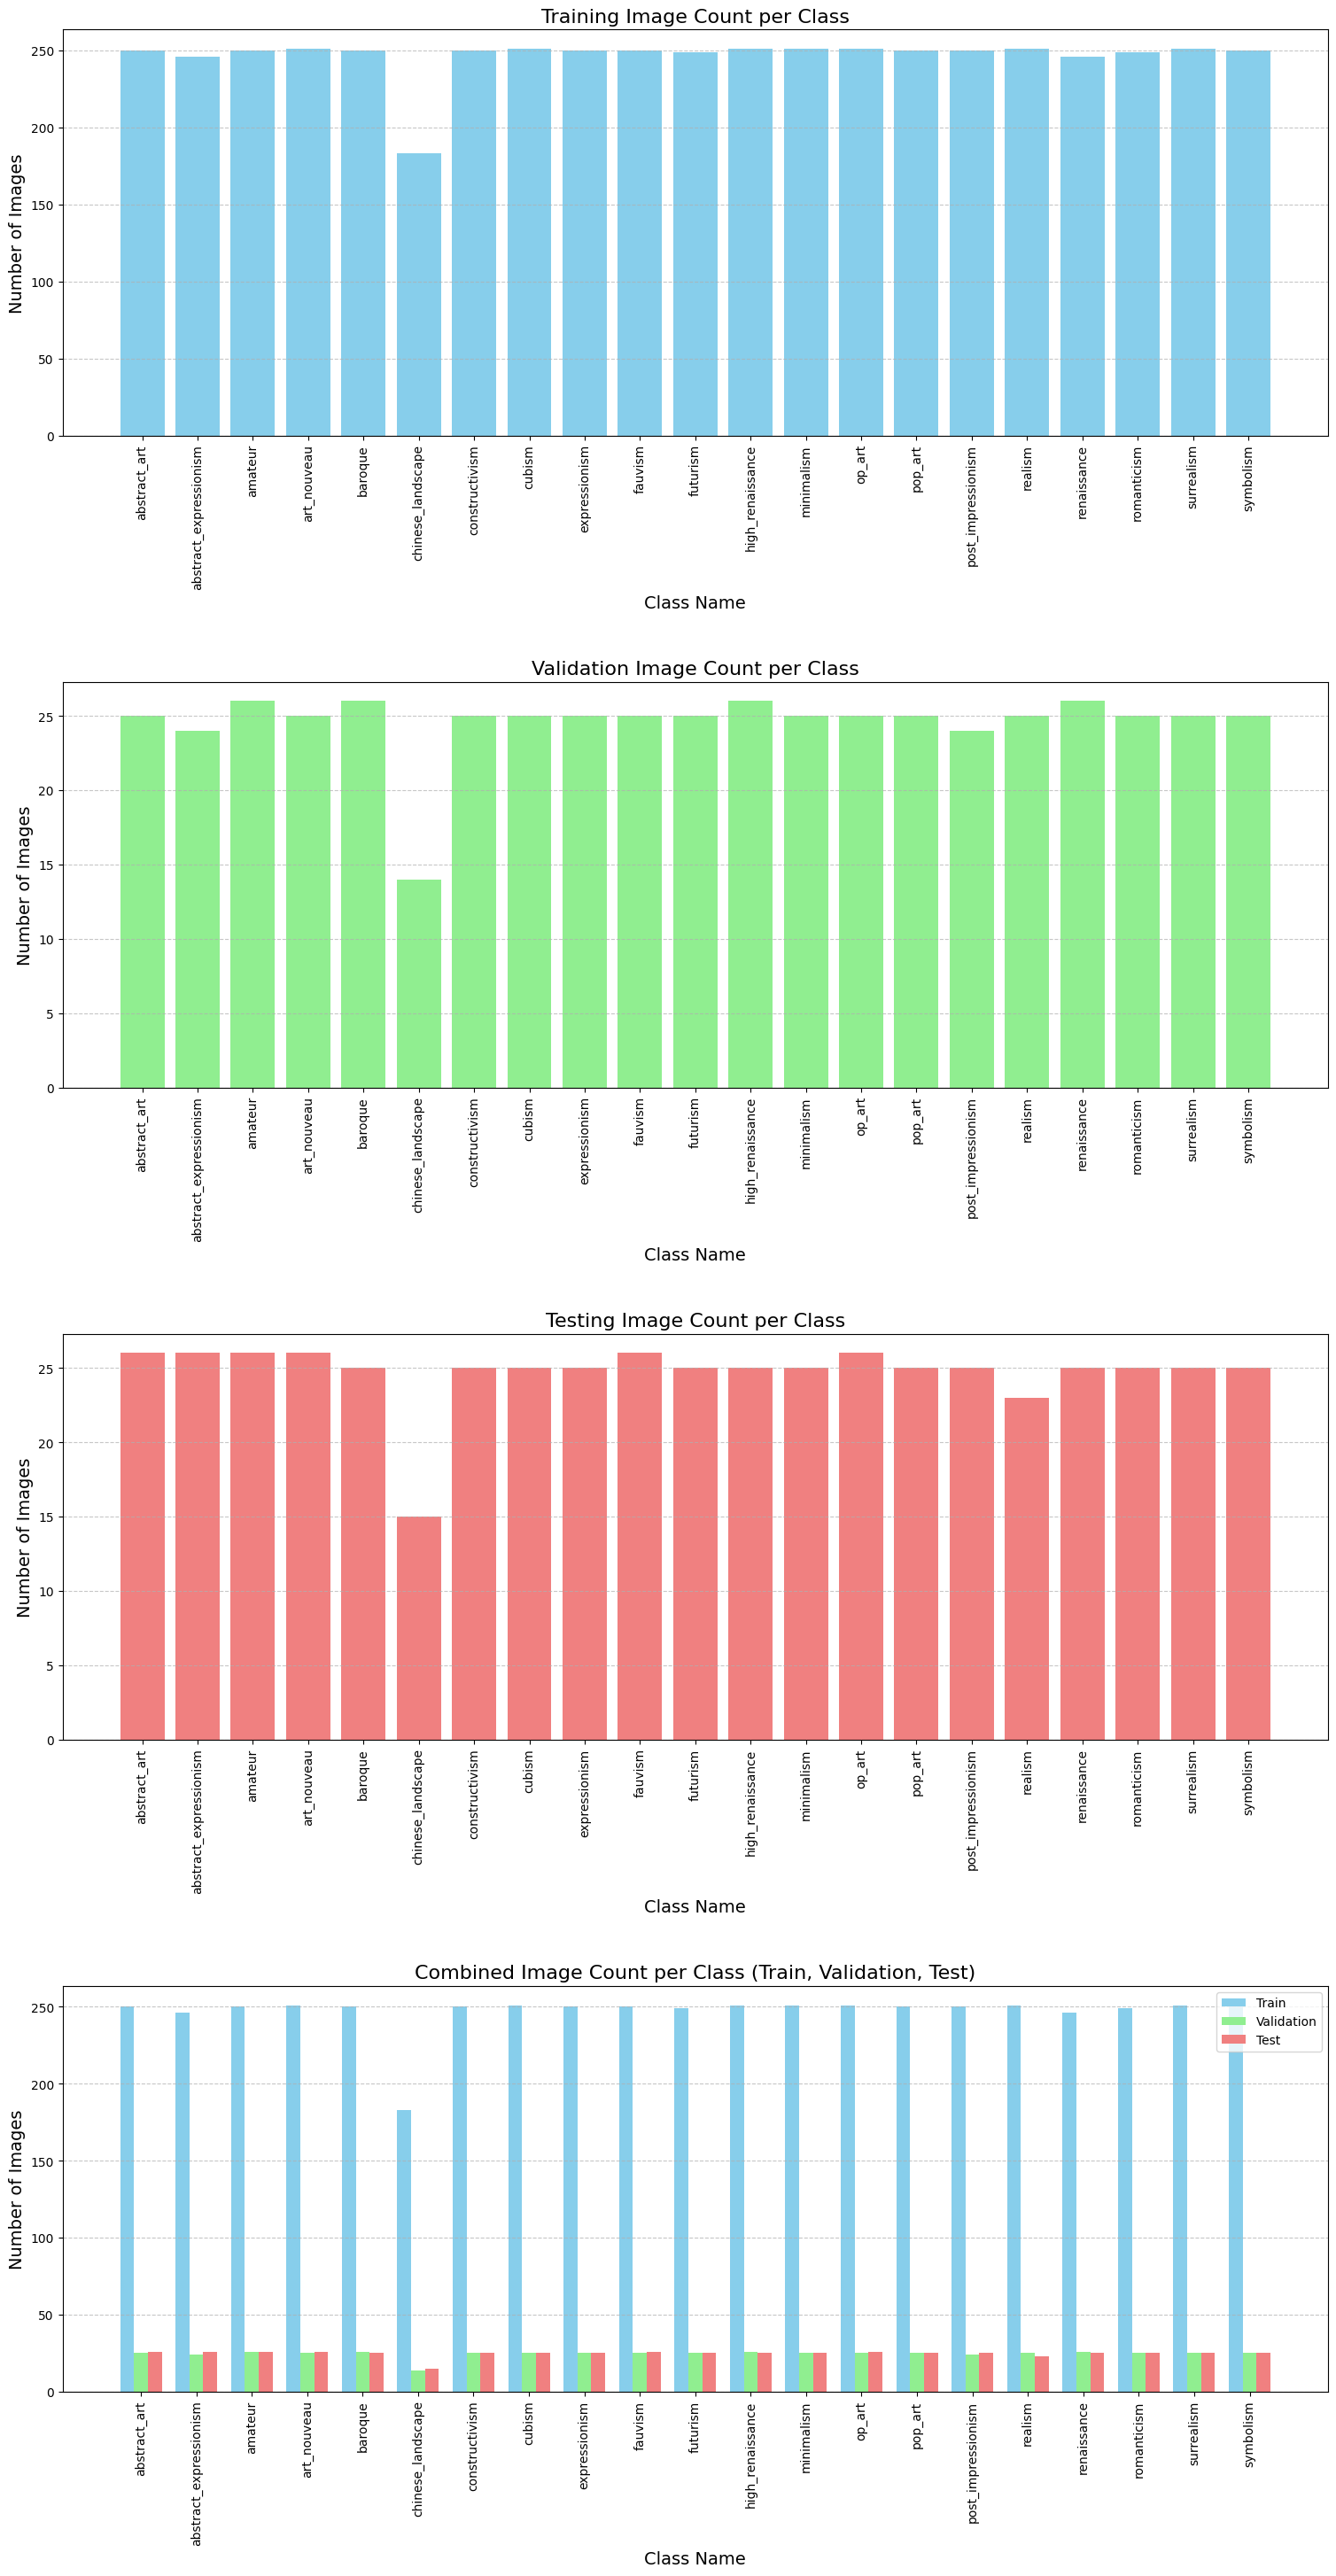

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"  # Update path if needed

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and initialize counters
class_names = train_dataset.classes
train_image_counts, val_image_counts, test_image_counts = [], [], []

# Count images per class
for class_name in class_names:
    train_count = len(os.listdir(os.path.join(train_dataset.root, class_name)))
    val_count = len(os.listdir(os.path.join(val_dataset.root, class_name)))
    test_count = len(os.listdir(os.path.join(test_dataset.root, class_name)))

    train_image_counts.append(train_count)
    val_image_counts.append(val_count)
    test_image_counts.append(test_count)

# Create vertically stacked subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 30))  # Wider + taller for readability

# Common x-axis style
def style_x_axis(ax):
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90, fontsize=10)
    ax.set_xlabel("Class Name", fontsize=14)
    ax.set_ylabel("Number of Images", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Training set plot
axes[0].bar(range(len(class_names)), train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
style_x_axis(axes[0])

# Validation set plot
axes[1].bar(range(len(class_names)), val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
style_x_axis(axes[1])

# Test set plot
axes[2].bar(range(len(class_names)), test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
style_x_axis(axes[2])

# Combined view with grouped bars
bar_width = 0.25
x = list(range(len(class_names)))

axes[3].bar([i - bar_width for i in x], train_image_counts, width=bar_width, label='Train', color='skyblue')
axes[3].bar(x, val_image_counts, width=bar_width, label='Validation', color='lightgreen')
axes[3].bar([i + bar_width for i in x], test_image_counts, width=bar_width, label='Test', color='lightcoral')

axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xticks(x)
axes[3].set_xticklabels(class_names, rotation=90, fontsize=10)
axes[3].set_xlabel("Class Name", fontsize=14)
axes[3].set_ylabel("Number of Images", fontsize=14)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Final layout adjustments
plt.tight_layout(pad=4)
plt.show()


| **Hyperparameter**        | **Value**                                                                          | **Description**                                                    |
| ------------------------- | ---------------------------------------------------------------------------------- | ------------------------------------------------------------------ |
| **Model Architecture**    | `pvt_v2_b2`                                                                        | Pretrained Pyramid Vision Transformer v2 (B2 variant) from `timm`  |
| **Input Image Size**      | `224 x 224`                                                                        | Image size resized for model input                                 |
| **Batch Size**            | `16`                                                                               | Number of samples per mini-batch                                   |
| **Epochs**                | `25`                                                                               | Number of training iterations over the entire dataset              |
| **Learning Rate**         | `1e-4` (0.0001)                                                                    | Initial learning rate for the optimizer                            |
| **Optimizer**             | `AdamW`                                                                            | Optimizer used for updating model parameters                       |
| **Weight Decay**          | `1e-5` (0.00001)                                                                   | Regularization term to prevent overfitting                         |
| **Loss Function**         | `CrossEntropyLoss`                                                                 | Standard classification loss function                              |
| **Data Augmentation**     | `Resize(224x224)`, `RandomHorizontalFlip`,<br>`RandomRotation(10°)`, `ColorJitter` | Enhances dataset variability and generalization                    |
| **Normalization Mean**    | `[0.485, 0.456, 0.406]`                                                            | ImageNet normalization mean values                                 |
| **Normalization Std Dev** | `[0.229, 0.224, 0.225]`                                                            | ImageNet normalization std values                                  |
| **Dropout (Head Layer)**  | `0.5` (first), `0.3` (second)                                                      | Dropout applied before classification layers to reduce overfitting |
| **Intermediate FC Layer** | `512 units + ReLU + BatchNorm1d`                                                   | Custom head for learning representation before output              |
| **Evaluation Metric**     | `Accuracy`, `Precision`, `Recall`, `F1`                                            | Evaluation metrics computed on the test set                        |
| **Device**                | `CUDA` if available, else `CPU`                                                    | GPU acceleration used if available                                 |


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from tqdm import tqdm
import time

# ======== Device Configuration ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== Data Transforms (PVTv2 expects 224x224 input) ========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ======== Dataset and DataLoaders ========
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_data = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_data = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

print(f"Train samples: {len(train_data)} | Val samples: {len(val_data)} | Test samples: {len(test_data)}")

batch_size = 16  # Reduced for PVTv2
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# ======== PVTv2 Model Definition ========
class ArtworkClassificationPVTv2(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationPVTv2, self).__init__()
        self.backbone = timm.create_model("pvt_v2_b2", pretrained=True)

        # Replace head
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

model = ArtworkClassificationPVTv2(num_classes=len(train_data.classes)).to(device)

# ======== Loss Function and Optimizer ========
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ======== Training Loop ========
num_epochs = 25
train_losses = []
val_losses = []
val_accuracies = []
epoch_times = []

print("\nStarting Training...\n")
for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            tepoch.set_postfix(loss=loss.item())

    train_loss_epoch = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss_epoch)

    # ======== Validation ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_accuracy)

    epoch_duration = time.time() - epoch_start
    epoch_times.append(epoch_duration)

    print(f"Epoch {epoch+1} Completed | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | Val Acc: {val_accuracy*100:.2f}% | Time: {epoch_duration:.2f}s")

total_training_time = sum(epoch_times)
print(f"\nTotal Training Time: {total_training_time:.2f}s ({total_training_time/60:.2f} minutes)")

# ======== Plotting ========

# Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss", color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), val_accuracies, label="Val Accuracy", color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Time Per Epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), epoch_times, marker='o', color='purple')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ======== Evaluation on Test Set ========
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# ======== Classification Report & Confusion Matrix ========
report = classification_report(all_labels, all_preds, target_names=train_data.classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("\nPrecision, Recall, F1-Score Table:\n")
print(df_report[['precision', 'recall', 'f1-score']].round(3))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Train samples: 5168 | Val samples: 512 | Test samples: 511


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/101M [00:00<?, ?B/s]


Starting Training...



Epoch 1/25 Training: 100%|██████████| 323/323 [03:26<00:00,  1.56it/s, loss=2.31]


Epoch 1 Completed | Train Loss: 2.9249 | Val Loss: 2.5045 | Val Acc: 21.29% | Time: 214.07s


Epoch 2/25 Training: 100%|██████████| 323/323 [03:28<00:00,  1.55it/s, loss=1.49]


Epoch 2 Completed | Train Loss: 2.0903 | Val Loss: 1.6377 | Val Acc: 49.61% | Time: 214.92s


Epoch 3/25 Training: 100%|██████████| 323/323 [03:28<00:00,  1.55it/s, loss=0.928]


Epoch 3 Completed | Train Loss: 1.3739 | Val Loss: 1.4829 | Val Acc: 53.91% | Time: 215.13s


Epoch 4/25 Training: 100%|██████████| 323/323 [03:32<00:00,  1.52it/s, loss=0.927]


Epoch 4 Completed | Train Loss: 0.9850 | Val Loss: 1.4559 | Val Acc: 55.66% | Time: 219.24s


Epoch 5/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.942]


Epoch 5 Completed | Train Loss: 0.7236 | Val Loss: 1.4138 | Val Acc: 62.30% | Time: 214.88s


Epoch 6/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.293]


Epoch 6 Completed | Train Loss: 0.5083 | Val Loss: 1.5128 | Val Acc: 58.40% | Time: 213.64s


Epoch 7/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.55it/s, loss=0.417]


Epoch 7 Completed | Train Loss: 0.3702 | Val Loss: 1.4210 | Val Acc: 61.52% | Time: 214.72s


Epoch 8/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.55it/s, loss=0.326]


Epoch 8 Completed | Train Loss: 0.2936 | Val Loss: 1.4367 | Val Acc: 65.23% | Time: 214.96s


Epoch 9/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.214]


Epoch 9 Completed | Train Loss: 0.2360 | Val Loss: 1.5813 | Val Acc: 59.77% | Time: 213.93s


Epoch 10/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.169]


Epoch 10 Completed | Train Loss: 0.1907 | Val Loss: 1.7049 | Val Acc: 61.52% | Time: 214.31s


Epoch 11/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.55it/s, loss=0.151]


Epoch 11 Completed | Train Loss: 0.1698 | Val Loss: 1.4887 | Val Acc: 63.28% | Time: 215.04s


Epoch 12/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.121]


Epoch 12 Completed | Train Loss: 0.1152 | Val Loss: 1.6991 | Val Acc: 61.52% | Time: 214.02s


Epoch 13/25 Training: 100%|██████████| 323/323 [03:26<00:00,  1.56it/s, loss=0.26]


Epoch 13 Completed | Train Loss: 0.1518 | Val Loss: 1.9674 | Val Acc: 58.79% | Time: 213.63s


Epoch 14/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.182]


Epoch 14 Completed | Train Loss: 0.1422 | Val Loss: 1.5603 | Val Acc: 66.02% | Time: 214.29s


Epoch 15/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.0681]


Epoch 15 Completed | Train Loss: 0.1167 | Val Loss: 1.5993 | Val Acc: 64.45% | Time: 213.95s


Epoch 16/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.0898]


Epoch 16 Completed | Train Loss: 0.0994 | Val Loss: 1.8494 | Val Acc: 61.72% | Time: 214.73s


Epoch 17/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.0373]


Epoch 17 Completed | Train Loss: 0.1342 | Val Loss: 1.9066 | Val Acc: 63.09% | Time: 214.59s


Epoch 18/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.0105]


Epoch 18 Completed | Train Loss: 0.0924 | Val Loss: 1.8411 | Val Acc: 64.65% | Time: 214.07s


Epoch 19/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.55it/s, loss=0.546]


Epoch 19 Completed | Train Loss: 0.1122 | Val Loss: 1.8932 | Val Acc: 62.70% | Time: 214.74s


Epoch 20/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.55it/s, loss=0.0468]


Epoch 20 Completed | Train Loss: 0.0943 | Val Loss: 1.8262 | Val Acc: 65.82% | Time: 214.91s


Epoch 21/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.143]


Epoch 21 Completed | Train Loss: 0.0826 | Val Loss: 1.9677 | Val Acc: 61.13% | Time: 213.63s


Epoch 22/25 Training: 100%|██████████| 323/323 [03:27<00:00,  1.56it/s, loss=0.0176]


Epoch 22 Completed | Train Loss: 0.0795 | Val Loss: 2.0369 | Val Acc: 58.59% | Time: 214.61s


Epoch 23/25 Training:  80%|███████▉  | 257/323 [02:45<00:46,  1.41it/s, loss=0.61]  